In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import ttest_ind

In [85]:
compas = pd.read_csv("compas-scores-two-years.csv")
compas

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [86]:
# copy the pre-processing steps from "Loading Data" found on: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
compas = compas[(compas["days_b_screening_arrest"] <= 30) & (compas["days_b_screening_arrest"] >= -30)]

# nr of rows match those in link
compas

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [87]:
# separate labels
compas_y = compas["two_year_recid"]
compas_X = compas.drop("two_year_recid", axis=1)

In [88]:
compas_X = compas_X[["age", "race", "c_charge_degree", "age_cat", "score_text", "sex", "priors_count", 
                    "days_b_screening_arrest", "decile_score", "sex", "race", "in_custody", "out_custody"]]

In [89]:
# # convert dates to just years and numerical types
# def date_to_justyear(date):
#     if type(date) == str:
#         return int(date[:4])
    
#     return date

# for column in ["c_jail_in", "c_jail_out"]:
#     compas_X[column] = compas_X[column].apply(func=date_to_justyear, convert_dtype=True)
    

In [90]:
# separate sensitive attributes
compas_sex = compas_X["sex"]
compas_race = compas_X["race"]
compas_X = compas_X.drop(["race", "sex"], axis=1)

In [91]:
# convert to one-hot-encoding
compas_cat_X = pd.get_dummies(compas_X)
compas_cat_X

,age,priors_count,days_b_screening_arrest,decile_score,c_charge_degree_F,c_charge_degree_M,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,score_text_High,...,out_custody_2016-03-30,out_custody_2016-04-01,out_custody_2016-04-04,out_custody_2016-04-05,out_custody_2016-04-08,out_custody_2016-04-09,out_custody_2016-04-11,out_custody_2016-04-18,out_custody_2016-04-19,out_custody_2020-01-01
0,69,0,-1.0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34,0,-1.0,3,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24,4,-1.0,4,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,44,0,0.0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,41,14,-1.0,6,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,23,0,-1.0,7,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7210,23,0,-1.0,3,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7211,57,0,-1.0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7212,33,3,-1.0,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
# impute the numerical missing values with the median
compas_cat_X = compas_cat_X.fillna(compas_cat_X.median())

In [93]:
# make a train and test split with same proportional size as Adult dataset
compas_train_cat_X, compas_test_cat_X, compas_train_y, compas_test_y= train_test_split(compas_cat_X, compas_y, test_size=1/3, random_state=42)

# also for the sensitive attributes with same random_state
compas_train_sex, compas_test_sex, compas_train_y, compas_test_y = train_test_split(compas_sex, compas_y, test_size=1/3, random_state=42)
compas_train_race, compas_test_race, compas_train_y, compas_test_y = train_test_split(compas_race, compas_y, test_size=1/3, random_state=42)

In [94]:
# construct decision tree
tree = DecisionTreeClassifier(random_state=42)

parameter_grid={"criterion":["entropy"], "max_depth":[2, 3, 4], 
                "max_features":["sqrt", None, "log2"], 
                "max_leaf_nodes":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
tree_cv = GridSearchCV(tree, param_grid=parameter_grid, scoring='balanced_accuracy', n_jobs=2, cv=3, verbose=2)
tree_cv.fit(compas_train_cat_X, compas_train_y)
best_tree = tree_cv.best_estimator_
best_tree

Fitting 3 folds for each of 90 candidates, totalling 270 fits


DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=10,
                       random_state=42)

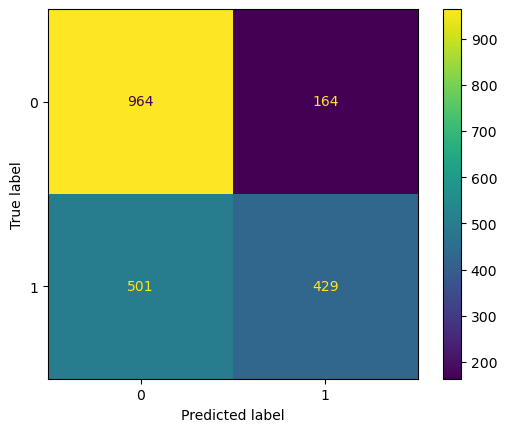

In [95]:
# confusion matrix / performance on testset
y_pred = best_tree.predict(compas_test_cat_X)
cm = confusion_matrix(compas_test_y, y_pred, labels=best_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_tree.classes_)
disp.plot()

In [96]:
print(f"Balanced accuracy on test set: {balanced_accuracy_score(compas_test_y, y_pred)}")
print(f"ROC-AUC score on test set: {roc_auc_score(compas_test_y, y_pred)}")
print(f"Accuracy score: {accuracy_score(compas_test_y, y_pred)}")

Balanced accuracy on test set: 0.6579501258293297
ROC-AUC score on test set: 0.6579501258293298
Accuracy score: 0.6768707482993197


In [97]:
column_names = [name for name in compas_train_cat_X.columns]
print(export_text(best_tree, feature_names=column_names))

|--- score_text_Low <= 0.50
|   |--- priors_count <= 2.50
|   |   |--- age <= 20.50
|   |   |   |--- class: 1
|   |   |--- age >  20.50
|   |   |   |--- class: 0
|   |--- priors_count >  2.50
|   |   |--- score_text_Medium <= 0.50
|   |   |   |--- class: 1
|   |   |--- score_text_Medium >  0.50
|   |   |   |--- class: 1
|--- score_text_Low >  0.50
|   |--- priors_count <= 1.50
|   |   |--- decile_score <= 1.50
|   |   |   |--- class: 0
|   |   |--- decile_score >  1.50
|   |   |   |--- age <= 22.50
|   |   |   |   |--- class: 0
|   |   |   |--- age >  22.50
|   |   |   |   |--- class: 0
|   |--- priors_count >  1.50
|   |   |--- age <= 25.50
|   |   |   |--- class: 1
|   |   |--- age >  25.50
|   |   |   |--- priors_count <= 8.50
|   |   |   |   |--- class: 0
|   |   |   |--- priors_count >  8.50
|   |   |   |   |--- class: 1



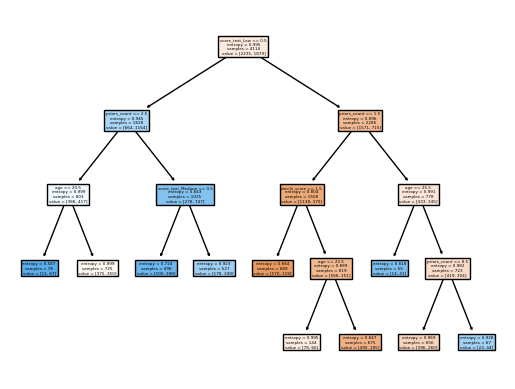

[CV] END criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, max_leaf_nodes=3; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, max_leaf_nodes=4; total time=   0.0s
[CV] END criterion=entropy,

In [98]:
plot_tree(best_tree, feature_names=compas_train_cat_X.columns, filled=True)
plt.savefig("compastree", dpi=800)
plt.show()